In [32]:
# default_exp flat
from diffusion_curvature.laziness import curvature
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

# Flat Walk Estimation

Using the multinomial distribution to estimate the laziness of a t-step random walk in an n-dimensional flat space. The multinomial distribution gives the t-step diffusion probabilities in the idealized space of $R^n$, tiled into cubes. 

$$ 
\mathbb{P}(X_{1}=x_{1}\dots X_{k}=x_{k}) = \frac{n!}{x_{1}!x_{2}!\dots x_{k}!}p_1^{x_{1}}\dots p_{k}^{x_{k}}
$$

In [33]:
import math
def multinomial(n,occurences,probs):
    assert np.sum(occurences) == n
    assert len(occurences) == len(probs)
    factorials = [math.factorial(occ) for occ in occurences]
    factorial_product = np.prod(factorials)
    probs_exp = [probs[i]**occurences[i] for i in range(len(occurences))]
    probs_product = np.prod(probs_exp)
    # put it all together
    pdf = math.factorial(n)/(factorial_product)*probs_product
    return pdf

In [34]:
multinomial(4,[1,2,1],[1/3,1/3,1/3])

0.14814814814814814

In [35]:
def nchoosek(n,k):
    # generates n!/k! ways of making k choices from n objects
    chosen = [[i] for i in range(n)]
    for kk in range(k-1):
        choosing_now = []
        for nn in range(n):
            for p in chosen:
                choosing_now.append(p + [nn])
        chosen = choosing_now
    return chosen

In [36]:
def nchoosek_ordered(n,k):
    chosen = [[i] for i in range(n)]
    for kk in range(k-1):
        choosing_now = []
        for c in chosen:
            for i in range(c[-1],n):
                choosing_now.append(c + [i])
        chosen = choosing_now
    return chosen

In [39]:
def partitions(n,k):
    # breaks n into k boxes. Returns a list of possible partitions
    # simpler to assign k-1 box boundaries to the n+1 spots betweeen, before and after the balls
    prepartitions = nchoosek_ordered(n+1, k - 1) # TODO: Likely a more efficient implementation exists
    # convert into partitions
    def partition_converter(x):
        return list(map(int.__sub__,(x + [n]),([0] + x)))
    partitions = list(map(partition_converter,prepartitions))
    return partitions

In [167]:
import numpy as np
def flat_laziness(dimension, num_steps, num_neighbors):
    # calculate parameters for estimation
    n = num_steps
    k = dimension*2
    probs = np.ones(k)/k
    # Get partitions of n into k pieces
    neighborhood_steps = partitions(n,k)
    # Take only k nearest neighbors
    neighborhood_steps = np.array(neighborhood_steps)
    neighb_coordinates = neighborhood_steps[:,:dimension] - neighborhood_steps[:,dimension:]
    print(neighb_coordinates)
    neighb_distances = np.sum(np.abs(neighb_coordinates),axis=1)
    print(neighb_distances)
    print("max distance",max(neighb_distances))
    print("min distance", min(neighb_distances))
    kth_smallest_distance = np.sort(neighb_distances)[num_neighbors]
    print("chosen distance",kth_smallest_distance)
    mask = (neighb_distances <= kth_smallest_distance)
    near_neighbor_steps = neighborhood_steps[mask]
    print("size of mask ", np.sum(mask.astype(int)))
    # get probability of walking to each neighbor in the num step radius, sum these, and declare it a laziness value
    total_prob = 0
    for neighb in near_neighbor_steps:
        m = multinomial(n, neighb, probs)
        if m < 0:
            print(m)
            print(neighb)
            print(probs)
        total_prob += m
    # divide by number of neighbors diffused to
    total_prob = total_prob / np.sum(mask.astype(int))
    return total_prob

In [117]:
flat_laziness(3,8,-1)

[[ 0  0 -8]
 [ 0 -1 -7]
 [ 0 -2 -6]
 ...
 [ 7  0  1]
 [ 7  1  0]
 [ 8  0  0]]
[8 8 8 ... 8 8 8]
max distance 8
chosen distance 8
size of mask  1287


0.0007770007770007787

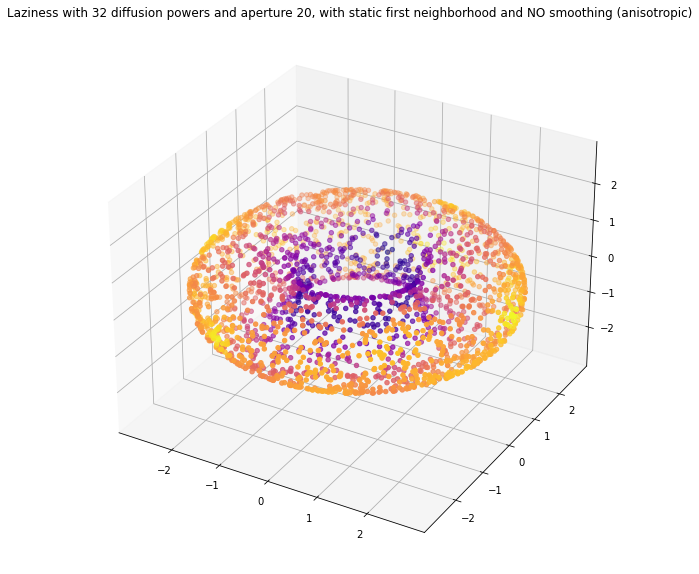

In [118]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import DiffusionMatrix, plot_3d
X,ks = torus(n=5000)
P_anis = DiffusionMatrix(X,kernel_type="adaptive anisotropic",k=20)
ks = curvature(P_anis,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=1, avg_transition_probability=True)
plot_3d(X,ks,title="Laziness with 32 diffusion powers and aperture 20, with static first neighborhood and NO smoothing (anisotropic)")

In [119]:
ks

array([0.00310042, 0.00310123, 0.00237617, ..., 0.00229878, 0.00312724,
       0.00315859])

In [120]:
ks_signed = ks - flat_laziness(2, 8, 20)

[[ 0 -8]
 [-1 -7]
 [-2 -6]
 [-3 -5]
 [-4 -4]
 [-5 -3]
 [-6 -2]
 [-7 -1]
 [-8  0]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [-7  1]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [-6  2]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [-5  3]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [-4  4]
 [ 0  2]
 [-1  3]
 [-2  4]
 [-3  5]
 [ 0  4]
 [-1  5]
 [-2  6]
 [ 0  6]
 [-1  7]
 [ 0  8]
 [ 1 -7]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [-2  4]
 [ 1  3]
 [ 0  4]
 [-1  5]
 [ 1  5]
 [ 0  6]
 [ 1  7]
 [ 2 -6]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [ 2 -4]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [ 2 -2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [ 2  0]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [ 2  2]
 [ 1  3]
 [ 0  4]
 [ 2  4]
 [ 1  5]
 [ 2  6]
 [ 3 -5]
 [ 2 -4]
 

In [121]:
flat_laziness(2, 8, 10)

[[ 0 -8]
 [-1 -7]
 [-2 -6]
 [-3 -5]
 [-4 -4]
 [-5 -3]
 [-6 -2]
 [-7 -1]
 [-8  0]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [-7  1]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [-6  2]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [-5  3]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [-4  4]
 [ 0  2]
 [-1  3]
 [-2  4]
 [-3  5]
 [ 0  4]
 [-1  5]
 [-2  6]
 [ 0  6]
 [-1  7]
 [ 0  8]
 [ 1 -7]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [-2  4]
 [ 1  3]
 [ 0  4]
 [-1  5]
 [ 1  5]
 [ 0  6]
 [ 1  7]
 [ 2 -6]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [ 2 -4]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [ 2 -2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [ 2  0]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [ 2  2]
 [ 1  3]
 [ 0  4]
 [ 2  4]
 [ 1  5]
 [ 2  6]
 [ 3 -5]
 [ 2 -4]
 

0.013660327808277027

In [122]:
plot_3d(X,ks_signed,title="signed curvature",use_plotly=True)

# Testing Against a Flat Surface

In [161]:
flat_space = np.random.rand(1000,5)

In [162]:
P_anis = DiffusionMatrix(flat_space,kernel_type="adaptive anisotropic",k=20)
ks = curvature(P_anis,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=False, avg_transition_probability=True)

In [163]:
ks

array([0.00103804, 0.00101278, 0.00097376, 0.00104573, 0.00101134,
       0.00105127, 0.00101929, 0.00101506, 0.        , 0.00105349,
       0.0010408 , 0.00100458, 0.00100979, 0.00099928, 0.00099618,
       0.00100552, 0.00103565, 0.00103657, 0.0010264 , 0.00103382,
       0.00103808, 0.00100988, 0.00102837, 0.00103967, 0.00103168,
       0.00102293, 0.00102003, 0.00098066, 0.00100603, 0.00105033,
       0.        , 0.00100427, 0.00101417, 0.00102108, 0.00103432,
       0.00100487, 0.00104168, 0.00100534, 0.0010113 , 0.0010004 ,
       0.00099443, 0.00101761, 0.00100565, 0.00103763, 0.00101035,
       0.00101235, 0.00104216, 0.0010252 , 0.00100274, 0.00101451,
       0.00101793, 0.00100549, 0.00101452, 0.00100919, 0.00101909,
       0.00103717, 0.00100187, 0.0009837 , 0.00101858, 0.00102744,
       0.00105094, 0.00101285, 0.00104824, 0.        , 0.0010099 ,
       0.00102191, 0.00102871, 0.00101223, 0.0010117 , 0.0010316 ,
       0.        , 0.00102518, 0.00103159, 0.00103422, 0.00100

In [164]:
np.mean(ks)

0.0009425964488074882

In [172]:
flat_laziness(5, 8, 10)

[[ 0  0  0  0 -8]
 [ 0  0  0 -1 -7]
 [ 0  0  0 -2 -6]
 ...
 [ 7  0  1  0  0]
 [ 7  1  0  0  0]
 [ 8  0  0  0  0]]
[8 8 8 ... 8 8 8]
max distance 8
min distance 0
chosen distance 0
size of mask  70


7.885000000000006e-05

In [180]:
from tqdm.notebook import trange
flats = []
lses = []
for dim in trange(2,10):
    flat_space = np.random.rand(1000,dim)
    P_anis = DiffusionMatrix(flat_space,kernel_type="adaptive anisotropic",k=20)
    ls = curvature(P_anis,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=False, avg_transition_probability=True)
    mean_ls = np.mean(ls)
    lses.append(mean_ls)
    flat_ls = flat_laziness(dim, 8, 10)
    flats.append(flat_ls)

  0%|          | 0/8 [00:00<?, ?it/s]

[[ 0 -8]
 [-1 -7]
 [-2 -6]
 [-3 -5]
 [-4 -4]
 [-5 -3]
 [-6 -2]
 [-7 -1]
 [-8  0]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [-7  1]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [-6  2]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [-5  3]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [-4  4]
 [ 0  2]
 [-1  3]
 [-2  4]
 [-3  5]
 [ 0  4]
 [-1  5]
 [-2  6]
 [ 0  6]
 [-1  7]
 [ 0  8]
 [ 1 -7]
 [ 0 -6]
 [-1 -5]
 [-2 -4]
 [-3 -3]
 [-4 -2]
 [-5 -1]
 [-6  0]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [-5  1]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [-4  2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [-3  3]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [-2  4]
 [ 1  3]
 [ 0  4]
 [-1  5]
 [ 1  5]
 [ 0  6]
 [ 1  7]
 [ 2 -6]
 [ 1 -5]
 [ 0 -4]
 [-1 -3]
 [-2 -2]
 [-3 -1]
 [-4  0]
 [ 2 -4]
 [ 1 -3]
 [ 0 -2]
 [-1 -1]
 [-2  0]
 [-3  1]
 [ 2 -2]
 [ 1 -1]
 [ 0  0]
 [-1  1]
 [-2  2]
 [ 2  0]
 [ 1  1]
 [ 0  2]
 [-1  3]
 [ 2  2]
 [ 1  3]
 [ 0  4]
 [ 2  4]
 [ 1  5]
 [ 2  6]
 [ 3 -5]
 [ 2 -4]
 

Text(0, 0.5, 'Laziness')

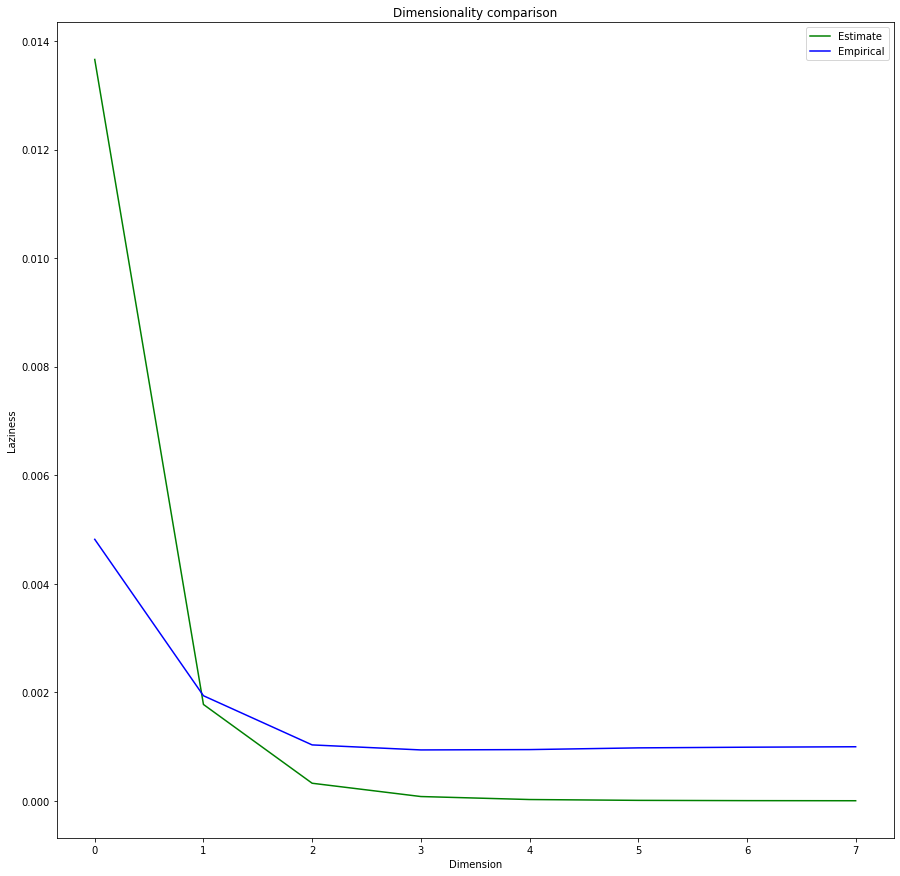

In [181]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,figsize=(15,15))
ax.plot(flats,color='green',label='Estimate')
ax.plot(lses,color='blue',label='Empirical')
ax.legend()
ax.set_title("Dimensionality comparison")
ax.set_xlabel("Dimension")
ax.set_ylabel("Laziness")